In [1]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Constants
e = 1.602176634e-19                   # Elementary charge (C)
m_e = 9.10938356e-31                  # Electron mass (kg)
hbar = 1.054571817e-34                # Reduced Planck's constant (J·s)
c = 3e8                               # Speed of light

gamma_1 = 0.39 * e                    # Interlayer coupling energy (J)
gamma_0 = 3.1 * e                     # Intralayer coupling energy between A and B sites
gamma_3 = 0.315 * e
gamma_4 = 0.044 * e
delta_prime = 0.047 * e

B_const = 30                          # Constant Magnetic field (T)
E_const = 155 * 1e6                   # Constant Electric Field (mV/nm) 

d = 3.35e-10
g = 2
a = 2.46e-10

v = (np.sqrt(3) * a * gamma_0) / (2 * hbar)     ## from T Chakraborty book
v3 = (np.sqrt(3) * a * gamma_3) / (2 * hbar)
v4 = (np.sqrt(3) * a * gamma_4) / (2 * hbar)

m_eff = gamma_1 / (2 * v**2)                    ## from T Chakraborty book
mu_B = (e * hbar) / (2 * m_eff)
l_B = np.sqrt((hbar * c) / (e * B_const))

epsilon_0 = 8.854187817e-12
epsilon_parallel = 6.6
epsilon_perpendicular = 3

In [3]:
import scipy.integrate as integrate
import scipy.special as sp

def V_SC(q, epsilon_parallel, B, d):
    """Effective Coulomb interaction in BLG."""
    return (56.2/ epsilon_parallel) * (np.sqrt(B)) * (2 * np.pi / q) * np.tanh(q * d)  ## gives value in meV

def hankel_transform(V_SC, r, B):
    """Computes the 2D Fourier (Hankel) transform of V_SC(q)."""
    integrand = lambda q: q * V_SC(q, epsilon_parallel, B, d) * sp.j0(q * r)
    result, _ = integrate.quad(integrand, 0, np.inf, limit=100)
    return result * 1e-3 * e

In [4]:
# Compute V(r) at r = 0 and r = a/3
r_A2 = a / np.sqrt(3)
r_B2 = 0

V_A2_const = hankel_transform(V_SC, r_A2, B_const)
V_B2_const = hankel_transform(V_SC, r_B2, B_const)

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


In [5]:
print("V_A2 : ", V_A2_const / e)  ## in eV
print("V_B2 : ", V_B2_const / e)  ## in eV

V_A2 :  4.908487625911069e-11
V_B2 :  4.908487744986595e-11


# Case 1 : E = 0, $ B \neq 0 $ and Zeeman splitting is not considered

In [6]:
# Function to construct the Hamiltonian matrix
def hamiltonian_matrix_K(n):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    delta_A2 = V_A2_const
    delta_B2 = V_B2_const
    omega_B = e * B_const / m_eff
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    
    H_K = np.array([
        [0, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, delta_A2 + delta_prime, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, delta_B2]
    ])
    return H_K

In [7]:
def hamiltonian_matrix_K_prime(n):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    delta_A2 = V_A2_const
    delta_B2 = V_B2_const
    omega_B = e * B_const / m_eff
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    
    H_K_prime = np.array([
        [0, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), gamma_1, delta_A2 + delta_prime, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, delta_B2]
    ])
    return H_K_prime

In [8]:
n_values = np.array([0,1])
E_K_0 = []
E_K_1 = []
E_K_2 = []
E_K_3 = []
for n in n_values:
    H_K = hamiltonian_matrix_K(n)
    eigvals_K = np.linalg.eigvalsh(H_K) / e  # Convert to eV
    E_K_0.append(eigvals_K[0])
    E_K_1.append(eigvals_K[1])
    E_K_2.append(eigvals_K[2])
    E_K_3.append(eigvals_K[3])    

E_K_0 = np.array(E_K_0)
E_K_1 = np.array(E_K_1)
E_K_2 = np.array(E_K_2)
E_K_3 = np.array(E_K_3)

In [9]:
E_K_prime_0 = []
E_K_prime_1 = []
E_K_prime_2 = []
E_K_prime_3 = []

for n in n_values:
    H_K_prime = hamiltonian_matrix_K_prime(n)
    eigvals_K_prime = np.linalg.eigvalsh(H_K_prime) / e  # Convert to eV
    E_K_prime_0.append(eigvals_K_prime[0])
    E_K_prime_1.append(eigvals_K_prime[1])
    E_K_prime_2.append(eigvals_K_prime[2])
    E_K_prime_3.append(eigvals_K_prime[3]) 

E_K_prime_0 = np.array(E_K_prime_0)
E_K_prime_1 = np.array(E_K_prime_1)
E_K_prime_2 = np.array(E_K_prime_2)
E_K_prime_3 = np.array(E_K_prime_3)

In [10]:
print("E_K_0 : ", E_K_0)
print("E_K_1 : ", E_K_1)
print("E_K_2 : ", E_K_2)
print("E_K_3 : ", E_K_3)

print('')
      
print("E_K_prime_0 : ", E_K_prime_0)
print("E_K_prime_1 : ", E_K_prime_1)
print("E_K_prime_2 : ", E_K_prime_2)
print("E_K_prime_3 : ", E_K_prime_3)

E_K_0 :  [-0.38384959 -0.40704314]
E_K_1 :  [-0.03102634 -0.05180944]
E_K_2 :  [0.03857109 0.06269843]
E_K_3 :  [0.47030484 0.49015416]

E_K_prime_0 :  [-0.35779445 -0.38384974]
E_K_prime_1 :  [-4.19886016e-10 -3.10248008e-02]
E_K_prime_2 :  [0.00304243 0.03856959]
E_K_prime_3 :  [0.44875202 0.47030495]


### Now plotting Energy eigenvalues against Magnetic field keeping E fixed at 155 mV/nm

In [11]:
# Magnetic field values
B_values = np.linspace(0, 30, 100)  # 100 values between 0 and 30T
n_values = list(range(2))  # n = 0 and n = 1  

# Store eigenvalues for all n
all_eigenvalues_K_var_B = np.zeros((len(n_values), len(B_values), 4))
all_eigenvalues_K_prime_var_B = np.zeros((len(n_values), len(B_values), 4))

In [12]:
def hamiltonian_matrix_K_var_B(n, omega_B, V_A2, V_B2, l_B):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    
    H_K_var_B = np.array([
        [0, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, V_A2 + delta_prime, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, V_B2]
    ])
    return H_K_var_B

In [13]:
def hamiltonian_matrix_K_prime_var_B(n, omega_B, V_A2, V_B2, l_B):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    
    H_K_prime_var_B = np.array([
        [0, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), gamma_1, V_A2 + delta_prime, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, V_B2]
    ])
    return H_K_prime_var_B

In [14]:
# Compute eigenvalues
for i, n in enumerate(n_values):
    for j, B in enumerate(B_values):
        omega_B = e * B / m_eff
        V_A2 = hankel_transform(V_SC, r_A2, B)
        V_B2 = hankel_transform(V_SC, r_B2, B)
        l_B = np.sqrt((hbar * c) / (e * B))
        H_K_var_B = hamiltonian_matrix_K_var_B(n, omega_B, V_A2, V_B2, l_B)
        H_K_prime_var_B = hamiltonian_matrix_K_prime_var_B(n, omega_B, V_A2, V_B2, l_B)
        eigvals_K_var_B = np.linalg.eigvalsh(H_K_var_B) / e  # Convert to eV
        eigvals_K_prime_var_B = np.linalg.eigvalsh(H_K_prime_var_B) / e  # Convert to eV
        all_eigenvalues_K_var_B[i, j, :] = eigvals_K_var_B
        all_eigenvalues_K_prime_var_B[i, j, :] = eigvals_K_prime_var_B

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


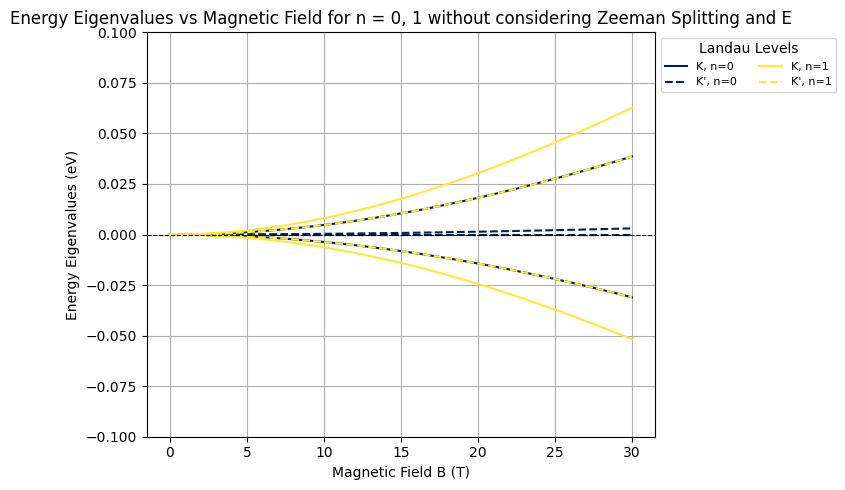

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.cividis(np.linspace(0, 1, len(n_values)))  # Color map for better visualization

for i, n in enumerate(n_values):
    for mode in range(4):  # There are 4 eigenvalues per n
        ax.plot(B_values, all_eigenvalues_K_var_B[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_K_prime_var_B[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")

ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1,0.1)
ax.set_title('Energy Eigenvalues vs Magnetic Field for n = 0, 1 without considering Zeeman Splitting and E')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # Show zero energy level
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Landau Levels")
ax.grid()

plt.tight_layout()

# Save the figure
plt.savefig("energy_vs_B_without_ZS_and_E.pdf", dpi=300, bbox_inches="tight")  # Saves as Pdf

plt.show()

# Case 2 : Now considering Zeeman Splitting and E = 0

In [16]:
### Considering Zeeman splitting

def hamiltonian_matrix_ZS_K(n):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    delta_A2 = V_A2_const
    delta_B2 = V_B2_const
    omega_B = e * B_const / m_eff
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    delta_ZS = g * mu_B * B_const
    
    H_ZS_K = np.array([
        [delta_ZS, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime + delta_ZS, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, delta_A2 + delta_prime + delta_ZS, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, delta_B2 + delta_ZS]
    ])
    return H_ZS_K

In [17]:
def hamiltonian_matrix_ZS_K_prime(n):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    delta_A2 = V_A2_const
    delta_B2 = V_B2_const
    omega_B = e * B_const / m_eff
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    delta_ZS = g * mu_B * B_const
    
    H_ZS_K_prime = np.array([
        [delta_ZS, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime + delta_ZS, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), gamma_1, delta_A2 + delta_prime + delta_ZS, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, delta_B2 + delta_ZS]
    ])
    return H_ZS_K_prime

In [18]:
n_values = np.array([0,1])
E_ZS_K_0 = []
E_ZS_K_1 = []
E_ZS_K_2 = []
E_ZS_K_3 = []
for n in n_values:
    H_ZS_K = hamiltonian_matrix_ZS_K(n)
    eigvals_ZS_K = np.linalg.eigvalsh(H_ZS_K) / e  # Convert to eV
    E_ZS_K_0.append(eigvals_ZS_K[0])
    E_ZS_K_1.append(eigvals_ZS_K[1])
    E_ZS_K_2.append(eigvals_ZS_K[2])
    E_ZS_K_3.append(eigvals_ZS_K[3])

E_ZS_K_0 = np.array(E_ZS_K_0)
E_ZS_K_1 = np.array(E_ZS_K_1)
E_ZS_K_2 = np.array(E_ZS_K_2)
E_ZS_K_3 = np.array(E_ZS_K_3)

In [19]:
E_ZS_K_prime_0 = []
E_ZS_K_prime_1 = []
E_ZS_K_prime_2 = []
E_ZS_K_prime_3 = []

for n in n_values:
    H_ZS_K_prime = hamiltonian_matrix_ZS_K_prime(n)
    eigvals_ZS_K_prime = np.linalg.eigvalsh(H_ZS_K_prime) / e  # Convert to eV
    E_ZS_K_prime_0.append(eigvals_ZS_K_prime[0])
    E_ZS_K_prime_1.append(eigvals_ZS_K_prime[1])
    E_ZS_K_prime_2.append(eigvals_ZS_K_prime[2])
    E_ZS_K_prime_3.append(eigvals_ZS_K_prime[3])

E_ZS_K_prime_0 = np.array(E_ZS_K_prime_0)
E_ZS_K_prime_1 = np.array(E_ZS_K_prime_1)
E_ZS_K_prime_2 = np.array(E_ZS_K_prime_2)
E_ZS_K_prime_3 = np.array(E_ZS_K_prime_3)

In [20]:
print("E_ZS_K_0 : ", E_ZS_K_0)
print("E_ZS_K_1 : ", E_ZS_K_1)
print("E_ZS_K_2 : ", E_ZS_K_2)
print("E_ZS_K_3 : ", E_ZS_K_3)

print('')

print("E_ZS_K_prime_0 : ", E_ZS_K_prime_0)
print("E_ZS_K_prime_1 : ", E_ZS_K_prime_1)
print("E_ZS_K_prime_2 : ", E_ZS_K_prime_2)
print("E_ZS_K_prime_3 : ", E_ZS_K_prime_3)

E_ZS_K_0 :  [-0.28190229 -0.30509584]
E_ZS_K_1 :  [0.07092096 0.05013786]
E_ZS_K_2 :  [0.14051839 0.16464573]
E_ZS_K_3 :  [0.57225215 0.59210146]

E_ZS_K_prime_0 :  [-0.25584715 -0.28190243]
E_ZS_K_prime_1 :  [0.1019473 0.0709225]
E_ZS_K_prime_2 :  [0.10498974 0.14051689]
E_ZS_K_prime_3 :  [0.55069933 0.57225225]


### Now plotting Energy eigenvalues against Magnetic field keeping E fixed at 155 mV/nm

In [21]:
# Magnetic field values
B_values = np.linspace(0, 30, 100)  # 100 values between 0 and 30T
n_values = list(range(2))  # n = 0 and n = 1  

# Store eigenvalues for all n
all_eigenvalues_ZS_K_var_B = np.zeros((len(n_values), len(B_values), 4))
all_eigenvalues_ZS_K_prime_var_B = np.zeros((len(n_values), len(B_values), 4))

In [22]:
def hamiltonian_matrix_ZS_K_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    
    H_ZS_K_var_B = np.array([
        [delta_ZS, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime + delta_ZS, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, V_A2 + delta_prime + delta_ZS, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, V_B2 + delta_ZS]
    ])
    return H_ZS_K_var_B

In [23]:
def hamiltonian_matrix_ZS_K_prime_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    
    H_ZS_K_prime_var_B = np.array([
        [delta_ZS, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime + delta_ZS, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), gamma_1, V_A2 + delta_prime + delta_ZS, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, V_B2 + delta_ZS]
    ])
    return H_ZS_K_prime_var_B

In [24]:
# Compute eigenvalues
for i, n in enumerate(n_values):
    for j, B in enumerate(B_values):
        omega_B = e * B / m_eff
        delta_ZS = g * mu_B * B
        V_A2 = hankel_transform(V_SC, r_A2, B)
        V_B2 = hankel_transform(V_SC, r_B2, B)
        l_B = np.sqrt((hbar * c)/ (e * B))
        H_ZS_K_var_B = hamiltonian_matrix_ZS_K_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)
        H_ZS_K_prime_var_B = hamiltonian_matrix_ZS_K_prime_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)
        eigvals_ZS_K_var_B = np.linalg.eigvalsh(H_ZS_K_var_B) / e  # Convert to eV
        eigvals_ZS_K_prime_var_B = np.linalg.eigvalsh(H_ZS_K_prime_var_B) / e  # Convert to eV
        all_eigenvalues_ZS_K_var_B[i, j, :] = eigvals_ZS_K_var_B
        all_eigenvalues_ZS_K_prime_var_B[i, j, :] = eigvals_ZS_K_prime_var_B

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


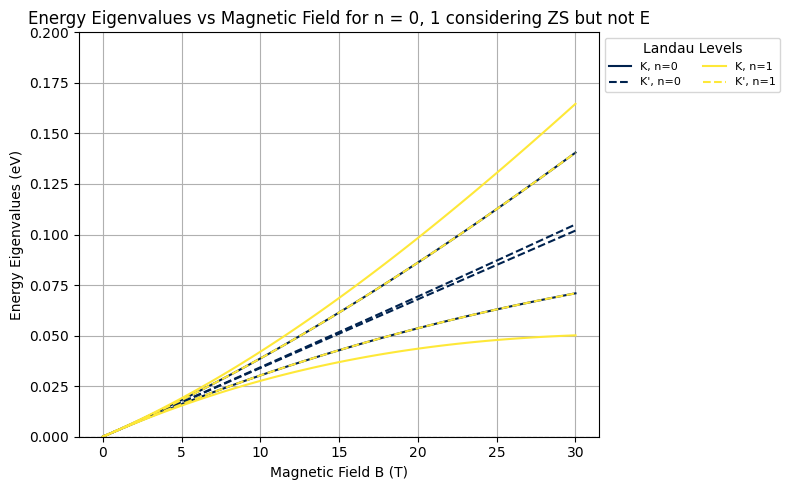

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.cividis(np.linspace(0, 1, len(n_values)))  # Color map for better visualization

for i, n in enumerate(n_values):
    for mode in range(4):  # There are 4 eigenvalues per n
        ax.plot(B_values, all_eigenvalues_ZS_K_var_B[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")

ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(0, 0.2)
ax.set_title('Energy Eigenvalues vs Magnetic Field for n = 0, 1 considering ZS but not E')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # Show zero energy level
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Landau Levels")
ax.grid()

plt.tight_layout()

# Save the figure
plt.savefig("energy_vs_B_considering_ZS_but_not_E.pdf", dpi=300, bbox_inches="tight")  # Saves as Pdf

plt.show()

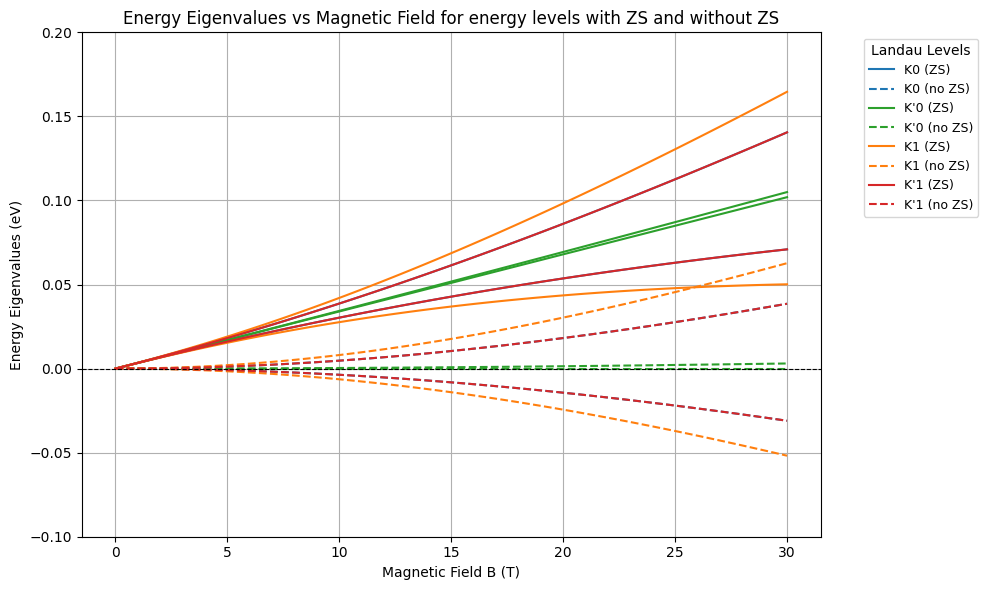

In [26]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Define 4 distinct colors for n=0/1 and K/K'
colors = {
    'K0': 'tab:blue',
    'K1': 'tab:orange',
    "K'0": 'tab:green',
    "K'1": 'tab:red'
}

# Line styles
linestyles = {
    'ZS': '-',   # With Zeeman Splitting
    'no_ZS': '--'  # Without Zeeman Splitting
}

# Plotting
for i, n in enumerate(n_values):  # Assuming n_values = [0, 1]
    # Label keys
    key_K = f'K{n}'
    key_Kp = f"K'{n}"

    # Only label once per curve
    label_K_ZS = f'{key_K} (ZS)'
    label_K_no_ZS = f'{key_K} (no ZS)'
    label_Kp_ZS = f"{key_Kp} (ZS)"
    label_Kp_no_ZS = f"{key_Kp} (no ZS)"

    for mode in range(4):
        ax.plot(B_values, all_eigenvalues_ZS_K_var_B[i, :, mode], color=colors[key_K], linestyle=linestyles['ZS'], label=label_K_ZS if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_K_var_B[i, :, mode], color=colors[key_K], linestyle=linestyles['no_ZS'], label=label_K_no_ZS if mode == 0 else "")

        ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B[i, :, mode], color=colors[key_Kp], linestyle=linestyles['ZS'], label=label_Kp_ZS if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_K_prime_var_B[i, :, mode], color=colors[key_Kp], linestyle=linestyles['no_ZS'], label=label_Kp_no_ZS if mode == 0 else "")

# Aesthetics
ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1, 0.2)
ax.set_title('Energy Eigenvalues vs Magnetic Field for energy levels with ZS and without ZS')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # zero energy line
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9, title="Landau Levels")
ax.grid(True)

plt.tight_layout()
plt.savefig("energy_vs_B_with_and_without_ZS_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Case 3 : Now electric field $ E \neq 0 $ and Zeeman Splitting is considered

In [27]:
def hamiltonian_matrix_ZS_EF_K(n):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    potential_diff_const = e * E_const * (d / 2)
    delta_A2 = V_A2_const
    delta_B2 = V_B2_const
    omega_B = e * B_const / m_eff
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    delta_ZS = g * mu_B * B_const
    
    H_ZS_EF_K = np.array([
        [delta_ZS + potential_diff_const, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime + delta_ZS + potential_diff_const, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, delta_A2 + delta_prime + delta_ZS - potential_diff_const, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, delta_B2 + delta_ZS - potential_diff_const]
    ])
    return H_ZS_EF_K

In [28]:
def hamiltonian_matrix_ZS_EF_K_prime(n):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    potential_diff_const = e * E_const * (d / 2)
    delta_A2 = V_A2_const
    delta_B2 = V_B2_const
    omega_B = e * B_const / m_eff
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    delta_ZS = g * mu_B * B_const
    
    H_ZS_EF_K_prime = np.array([
        [delta_ZS + potential_diff_const, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime + delta_ZS + potential_diff_const, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), gamma_1, delta_A2 + delta_prime + delta_ZS - potential_diff_const, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, delta_B2 + delta_ZS - potential_diff_const]
    ])
    return H_ZS_EF_K_prime

In [29]:
n_values = np.array([0,1])
E_ZS_EF_K_0 = []
E_ZS_EF_K_1 = []
E_ZS_EF_K_2 = []
E_ZS_EF_K_3 = []
for n in n_values:
    H_ZS_EF_K = hamiltonian_matrix_ZS_EF_K(n)
    eigvals_ZS_EF_K = np.linalg.eigvalsh(H_ZS_EF_K) / e  # Convert to eV
    E_ZS_EF_K_0.append(eigvals_ZS_EF_K[0])
    E_ZS_EF_K_1.append(eigvals_ZS_EF_K[1])
    E_ZS_EF_K_2.append(eigvals_ZS_EF_K[2])
    E_ZS_EF_K_3.append(eigvals_ZS_EF_K[3])

E_ZS_EF_K_0 = np.array(E_ZS_EF_K_0)
E_ZS_EF_K_1 = np.array(E_ZS_EF_K_1)
E_ZS_EF_K_2 = np.array(E_ZS_EF_K_2)
E_ZS_EF_K_3 = np.array(E_ZS_EF_K_3)

In [30]:
n_values = np.array([0,1])
E_ZS_EF_K_prime_0 = []
E_ZS_EF_K_prime_1 = []
E_ZS_EF_K_prime_2 = []
E_ZS_EF_K_prime_3 = []

for n in n_values:
    H_ZS_EF_K_prime = hamiltonian_matrix_ZS_EF_K_prime(n)
    eigvals_ZS_EF_K_prime = np.linalg.eigvalsh(H_ZS_EF_K_prime) / e  # Convert to eV
    E_ZS_EF_K_prime_0.append(eigvals_ZS_EF_K_prime[0])
    E_ZS_EF_K_prime_1.append(eigvals_ZS_EF_K_prime[1])
    E_ZS_EF_K_prime_2.append(eigvals_ZS_EF_K_prime[2])
    E_ZS_EF_K_prime_3.append(eigvals_ZS_EF_K_prime[3])

E_ZS_EF_K_prime_0 = np.array(E_ZS_EF_K_prime_0)
E_ZS_EF_K_prime_1 = np.array(E_ZS_EF_K_prime_1)
E_ZS_EF_K_prime_2 = np.array(E_ZS_EF_K_prime_2)
E_ZS_EF_K_prime_3 = np.array(E_ZS_EF_K_prime_3)

In [31]:
print("E_ZS_EF_K_0 : ", E_ZS_EF_K_0)
print("E_ZS_EF_K_1 : ", E_ZS_EF_K_1)
print("E_ZS_EF_K_2 : ", E_ZS_EF_K_2)
print("E_ZS_EF_K_3 : ", E_ZS_EF_K_3)

print('')

print("E_ZS_EF_K_prime_0 : ", E_ZS_EF_K_prime_0)
print("E_ZS_EF_K_prime_1 : ", E_ZS_EF_K_prime_1)
print("E_ZS_EF_K_prime_2 : ", E_ZS_EF_K_prime_2)
print("E_ZS_EF_K_prime_3 : ", E_ZS_EF_K_prime_3)

E_ZS_EF_K_0 :  [-0.2847335  -0.30785315]
E_ZS_EF_K_1 :  [0.06740371 0.04931289]
E_ZS_EF_K_2 :  [0.1471562  0.16835107]
E_ZS_EF_K_3 :  [0.5719628 0.5919784]

E_ZS_EF_K_prime_0 :  [-0.25877643 -0.28473365]
E_ZS_EF_K_prime_1 :  [0.08246156 0.06740505]
E_ZS_EF_K_prime_2 :  [0.1279098 0.1471549]
E_ZS_EF_K_prime_3 :  [0.55019428 0.57196291]


### Now plotting Energy eigenvalues against Magnetic field keeping E fixed at 155 mV/nm

In [32]:
# Magnetic field values
B_values = np.linspace(0, 30, 100)  # 100 values between 0 and 30T
n_values = list(range(2))  # n = 0 and n = 1  

# Store eigenvalues for all n
all_eigenvalues_ZS_EF_K_var_B = np.zeros((len(n_values), len(B_values), 4))
all_eigenvalues_ZS_EF_K_prime_var_B = np.zeros((len(n_values), len(B_values), 4))

In [33]:
def hamiltonian_matrix_ZS_EF_K_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    potential_diff_const = e * E_const * (d / 2)
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    
    H_ZS_EF_K_var_B = np.array([
        [delta_ZS + potential_diff_const, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime + delta_ZS + potential_diff_const, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, V_A2 + delta_prime + delta_ZS - potential_diff_const, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, V_B2 + delta_ZS - potential_diff_const]
    ])
    return H_ZS_EF_K_var_B

In [34]:
def hamiltonian_matrix_ZS_EF_K_prime_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    potential_diff_const = e * E_const * (d / 2)
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    
    H_ZS_EF_K_prime_var_B = np.array([
        [delta_ZS + potential_diff_const, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime + delta_ZS + potential_diff_const, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), gamma_1, V_A2 + delta_prime + delta_ZS - potential_diff_const, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, V_B2 + delta_ZS - potential_diff_const]
    ])
    return H_ZS_EF_K_prime_var_B

In [35]:
# Compute eigenvalues
for i, n in enumerate(n_values):
    for j, B in enumerate(B_values):
        omega_B = e * B / m_eff
        delta_ZS = g * mu_B * B
        V_A2 = hankel_transform(V_SC, r_A2, B)
        V_B2 = hankel_transform(V_SC, r_B2, B)
        l_B = np.sqrt((hbar * c)/(e * B))
        H_ZS_EF_K_var_B = hamiltonian_matrix_ZS_EF_K_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)
        H_ZS_EF_K_prime_var_B = hamiltonian_matrix_ZS_EF_K_prime_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)
        eigvals_ZS_EF_K_var_B = np.linalg.eigvalsh(H_ZS_EF_K_var_B) / e  # Convert to eV
        eigvals_ZS_EF_K_prime_var_B = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_B) / e  # Convert to eV
        all_eigenvalues_ZS_EF_K_var_B[i, j, :] = eigvals_ZS_EF_K_var_B
        all_eigenvalues_ZS_EF_K_prime_var_B[i, j, :] = eigvals_ZS_EF_K_prime_var_B

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


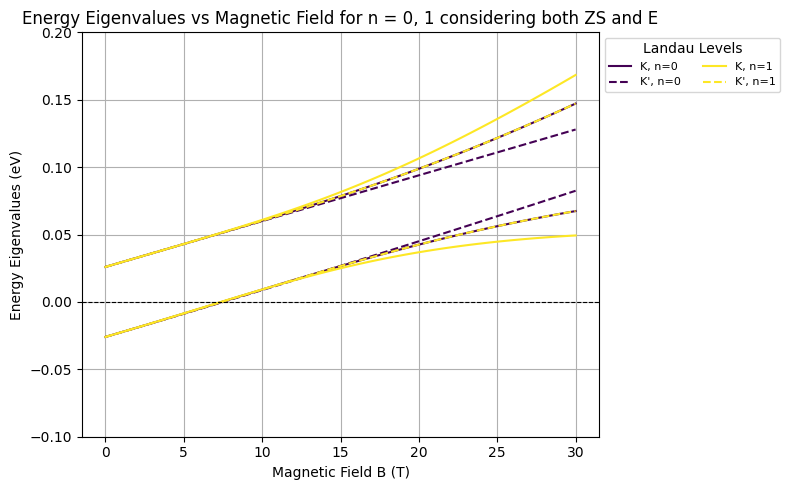

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(n_values)))  # Color map for better visualization

for i, n in enumerate(n_values):
    for mode in range(4):  # There are 4 eigenvalues per n
        ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")

ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1, 0.2)
ax.set_title('Energy Eigenvalues vs Magnetic Field for n = 0, 1 considering both ZS and E')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # Show zero energy level
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Landau Levels")
ax.grid()

plt.tight_layout()

# Save the figure
plt.savefig("energy_vs_B_considering_both_ZS_and_E.pdf", dpi=300, bbox_inches="tight")  # Saves as Pdf

plt.show()

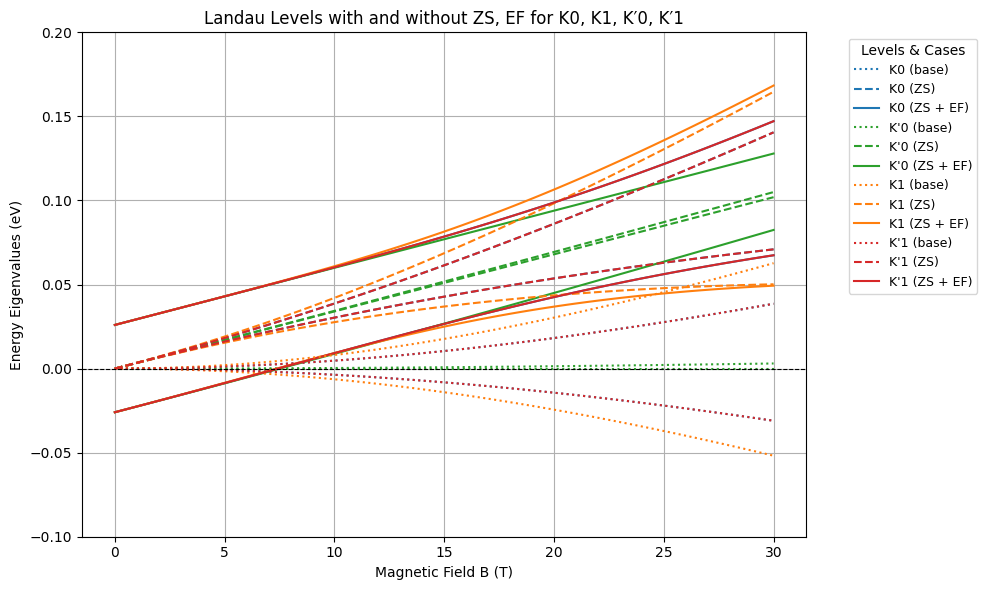

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Define 4 colors for 4 energy levels
colors = {
    'K0': 'tab:blue',
    'K1': 'tab:orange',
    "K'0": 'tab:green',
    "K'1": 'tab:red'
}

# Define line styles for the 3 physical cases
linestyles = {
    'base': ':',     # no ZS, no EF
    'ZS': '--',      # ZS only
    'ZS_EF': '-'     # ZS + EF
}

for i, n in enumerate(n_values):  # n_values = [0, 1]
    label_K = f'K{n}'
    label_Kp = f"K'{n}"

    for mode in range(4):
        if mode == 0:  # only label once per group
            ax.plot(B_values, all_eigenvalues_K_var_B[i, :, mode], color=colors[label_K], linestyle=linestyles['base'], label=f'{label_K} (base)')
            ax.plot(B_values, all_eigenvalues_ZS_K_var_B[i, :, mode], color=colors[label_K], linestyle=linestyles['ZS'], label=f'{label_K} (ZS)')
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B[i, :, mode], color=colors[label_K], linestyle=linestyles['ZS_EF'], label=f'{label_K} (ZS + EF)')

            ax.plot(B_values, all_eigenvalues_K_prime_var_B[i, :, mode], color=colors[label_Kp], linestyle=linestyles['base'], label=f"{label_Kp} (base)")
            ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B[i, :, mode], color=colors[label_Kp], linestyle=linestyles['ZS'], label=f"{label_Kp} (ZS)")
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B[i, :, mode], color=colors[label_Kp], linestyle=linestyles['ZS_EF'], label=f"{label_Kp} (ZS + EF)")
        else:
            ax.plot(B_values, all_eigenvalues_K_var_B[i, :, mode], color=colors[label_K], linestyle=linestyles['base'])
            ax.plot(B_values, all_eigenvalues_ZS_K_var_B[i, :, mode], color=colors[label_K], linestyle=linestyles['ZS'])
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B[i, :, mode], color=colors[label_K], linestyle=linestyles['ZS_EF'])

            ax.plot(B_values, all_eigenvalues_K_prime_var_B[i, :, mode], color=colors[label_Kp], linestyle=linestyles['base'])
            ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B[i, :, mode], color=colors[label_Kp], linestyle=linestyles['ZS'])
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B[i, :, mode], color=colors[label_Kp], linestyle=linestyles['ZS_EF'])

ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1, 0.2)
ax.set_title('Landau Levels with and without ZS, EF for K0, K1, K′0, K′1')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9, title="Levels & Cases")
ax.grid(True)
plt.tight_layout()
plt.savefig("energy_vs_B_with_and_without_ZS_and_E_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

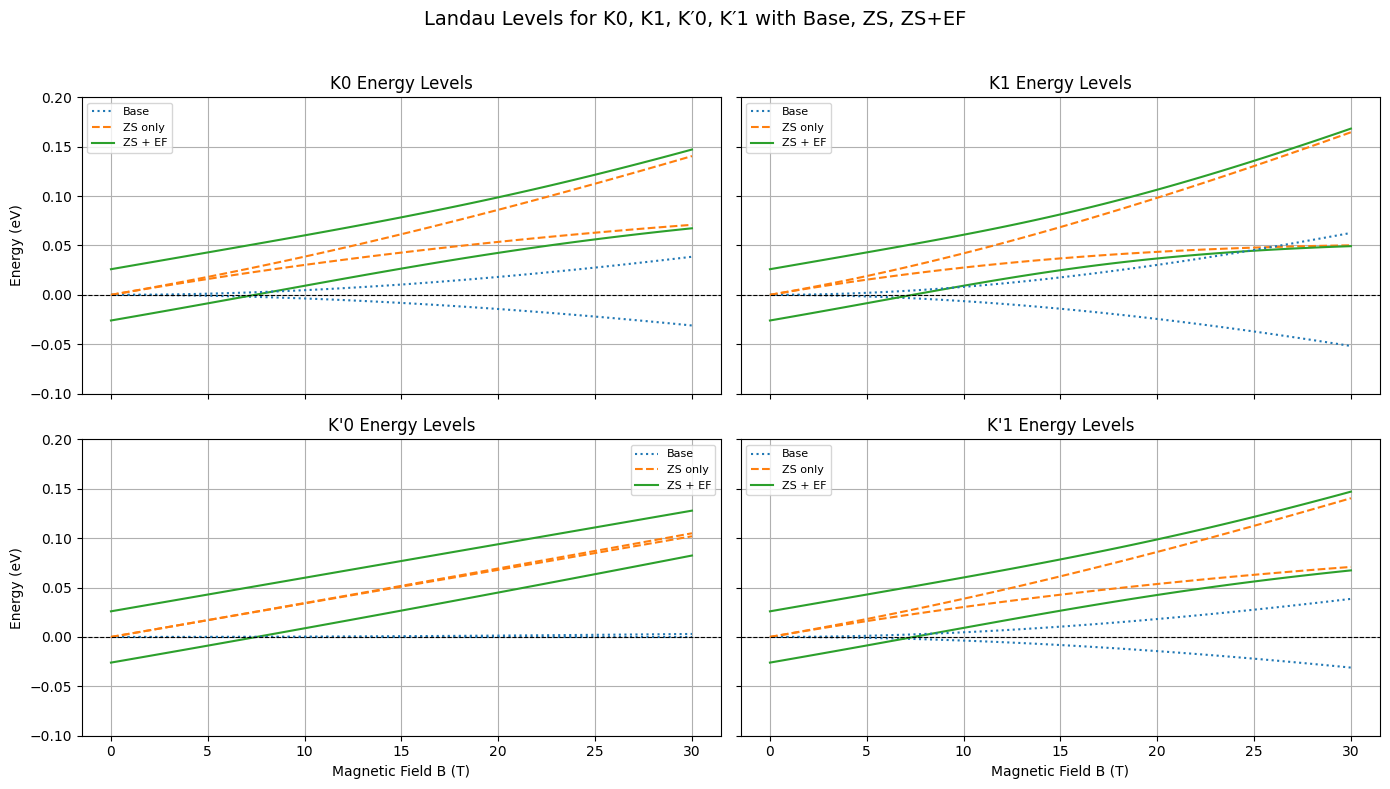

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axs = axs.flatten()

labels = ['K0', 'K1', "K'0", "K'1"]

# Now, assign different colors to different physical cases
case_colors = {
    'base': 'tab:blue',
    'ZS': 'tab:orange',
    'ZS_EF': 'tab:green'
}
case_linestyles = {
    'base': ':',
    'ZS': '--',
    'ZS_EF': '-'
}

for idx, ax in enumerate(axs):
    if idx < 2:
        i = idx  # K0, K1
        prefix = 'K'
        eigen_base = all_eigenvalues_K_var_B[i, :, :]
        eigen_ZS = all_eigenvalues_ZS_K_var_B[i, :, :]
        eigen_ZS_EF = all_eigenvalues_ZS_EF_K_var_B[i, :, :]
    else:
        i = idx - 2  # K′0, K′1
        prefix = "K'"
        eigen_base = all_eigenvalues_K_prime_var_B[i, :, :]
        eigen_ZS = all_eigenvalues_ZS_K_prime_var_B[i, :, :]
        eigen_ZS_EF = all_eigenvalues_ZS_EF_K_prime_var_B[i, :, :]

    label = f'{prefix}{i}'

    for mode in range(4):
        ax.plot(B_values, eigen_base[:, mode], color=case_colors['base'], linestyle=case_linestyles['base'], label='Base' if mode == 0 else "")
        ax.plot(B_values, eigen_ZS[:, mode], color=case_colors['ZS'], linestyle=case_linestyles['ZS'], label='ZS only' if mode == 0 else "")
        ax.plot(B_values, eigen_ZS_EF[:, mode], color=case_colors['ZS_EF'], linestyle=case_linestyles['ZS_EF'], label='ZS + EF' if mode == 0 else "")
        ax.set_ylim(-0.1,0.2)

    ax.set_title(f'{label} Energy Levels')
    ax.grid(True)
    if idx in [2, 3]:
        ax.set_xlabel('Magnetic Field B (T)')
    if idx in [0, 2]:
        ax.set_ylabel('Energy (eV)')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.legend(fontsize=8)

plt.suptitle('Landau Levels for K0, K1, K′0, K′1 with Base, ZS, ZS+EF', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("energy_vs_B_with_and_without_ZS_and_E_comparison_for_different_valley_and_orbital.pdf", dpi=300, bbox_inches="tight")
plt.show()


### Now plotting Energy eigenvalues against Electric field keeping B fixed at 30T

In [39]:
# Electric field values
E_values = np.linspace(0 * 1e6, 200 * 1e6, 100)  
n_values = list(range(2))  # n = 0, 1 and 2  

# Store eigenvalues for all n
all_eigenvalues_ZS_EF_K_var_E = np.zeros((len(n_values), len(E_values), 4))
all_eigenvalues_ZS_EF_K_prime_var_E = np.zeros((len(n_values), len(E_values), 4))

In [40]:
def hamiltonian_matrix_ZS_EF_K_var_E(n, potential_diff):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    omega_B = e * B_const / m_eff
    delta_A2 = V_A2_const
    delta_B2 = V_B2_const
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    delta_ZS = g * mu_B * B_const
    
    H_ZS_EF_K_var_E = np.array([
        [delta_ZS + potential_diff, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime + delta_ZS + potential_diff, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, delta_A2 + delta_prime + delta_ZS - potential_diff, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, delta_B2 + delta_ZS - potential_diff]
    ])
    return H_ZS_EF_K_var_E

In [41]:
def hamiltonian_matrix_ZS_EF_K_prime_var_E(n, potential_diff):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    delta_A2 = V_A2_const
    delta_B2 = V_B2_const
    omega_B = e * B_const / m_eff
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    delta_ZS = g * mu_B * B_const
    
    H_ZS_EF_K_prime_var_E = np.array([
        [delta_ZS + potential_diff, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime + delta_ZS + potential_diff, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), gamma_1, delta_A2 + delta_prime + delta_ZS - potential_diff, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, delta_B2 + delta_ZS - potential_diff]
    ])
    return H_ZS_EF_K_prime_var_E

In [42]:
# Compute eigenvalues
for i, n in enumerate(n_values):
    for j, E in enumerate(E_values):
        potential_diff = e * E * (d/2)
        H_ZS_EF_K_var_E = hamiltonian_matrix_ZS_EF_K_var_E(n, potential_diff)
        H_ZS_EF_K_prime_var_E = hamiltonian_matrix_ZS_EF_K_prime_var_E(n, potential_diff)
        eigvals_ZS_EF_K_var_E = np.linalg.eigvalsh(H_ZS_EF_K_var_E) / e  # Convert to eV
        eigvals_ZS_EF_K_prime_var_E = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_E) / e  # Convert to eV
        all_eigenvalues_ZS_EF_K_var_E[i, j, :] = eigvals_ZS_EF_K_var_E
        all_eigenvalues_ZS_EF_K_prime_var_E[i, j, :] = eigvals_ZS_EF_K_prime_var_E

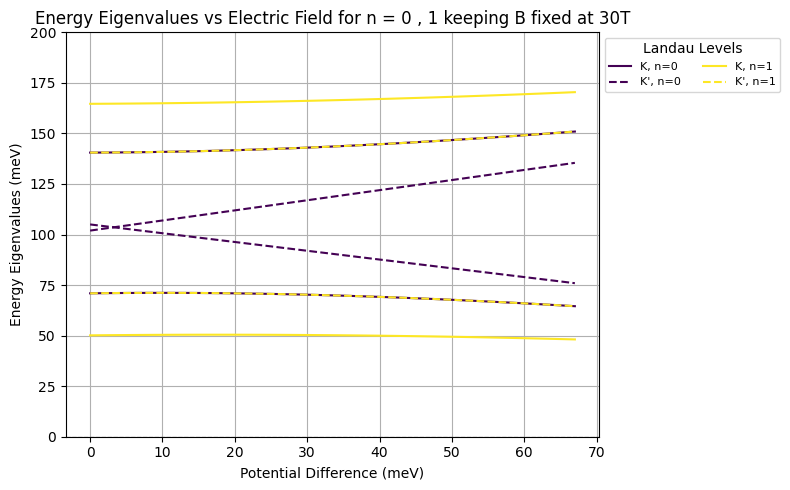

In [51]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(n_values)))  # Color map for better visualization

for i, n in enumerate(n_values):
    for mode in range(4):  # There are 4 eigenvalues per n
        ax.plot(1e3 * E_values * d, 1e3 * all_eigenvalues_ZS_EF_K_var_E[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        ax.plot(1e3 * E_values * d, 1e3 * all_eigenvalues_ZS_EF_K_prime_var_E[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")

ax.set_xlabel('Potential Difference (meV)')
ax.set_ylabel('Energy Eigenvalues (meV)')
ax.set_ylim(0,200)
ax.set_title('Energy Eigenvalues vs Electric Field for n = 0 , 1 keeping B fixed at 30T')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # Show zero energy level
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Landau Levels")
ax.grid()

plt.tight_layout()

# Save the figure
plt.savefig("energy_vs_E_at_constant_B.pdf", dpi=300, bbox_inches="tight")  # Saves as Pdf

plt.show()

### Now Plotting Energy eigenvalues against E and B

In [44]:
def hamiltonian_matrix_ZS_EF_K_var_B_var_E(n, potential_diff, omega_B, delta_ZS, V_A2, V_B2, l_B):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    
    H_ZS_EF_K_var_B_var_E = np.array([
        [delta_ZS + potential_diff, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime + delta_ZS + potential_diff, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, V_A2 + delta_prime + delta_ZS - potential_diff, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, V_B2 + delta_ZS - potential_diff]
    ])
    return H_ZS_EF_K_var_B_var_E

In [45]:
def hamiltonian_matrix_ZS_EF_K_prime_var_B_var_E(n, potential_diff, omega_B, delta_ZS, V_A2, V_B2, l_B):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    
    H_ZS_EF_K_prime_var_B_var_E = np.array([
        [delta_ZS + potential_diff, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime + delta_ZS + potential_diff, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), gamma_1, V_A2 + delta_prime + delta_ZS - potential_diff, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, V_B2 + delta_ZS - potential_diff]
    ])
    return H_ZS_EF_K_prime_var_B_var_E

In [46]:
# Store eigenvalues for all n, E, B combinations
all_eigenvalues_ZS_EF_K_var_B_var_E = np.zeros((len(n_values), len(E_values), len(B_values), 4))
all_eigenvalues_ZS_EF_K_prime_var_B_var_E = np.zeros((len(n_values), len(E_values), len(B_values), 4))

In [47]:
# Compute eigenvalues
for i, n in enumerate(n_values):
    for j, E in enumerate(E_values):
        for k, B in enumerate(B_values):
            potential_diff = e * E * (d/2)
            omega_B = e * B / m_eff
            delta_ZS = g * mu_B * B
            V_A2 = hankel_transform(V_SC, r_A2, B)
            V_B2 = hankel_transform(V_SC, r_B2, B)
            l_B = np.sqrt((hbar * c)/(e * B))
            H_ZS_EF_K_var_B_var_E = hamiltonian_matrix_ZS_EF_K_var_B_var_E(n, potential_diff, omega_B, delta_ZS, V_A2, V_B2, l_B)
            H_ZS_EF_K_prime_var_B_var_E = hamiltonian_matrix_ZS_EF_K_prime_var_B_var_E(n, potential_diff, omega_B, delta_ZS, V_A2, V_B2, l_B)
            eigvals_ZS_EF_K_var_B_var_E = np.linalg.eigvalsh(H_ZS_EF_K_var_B_var_E) / e  # Convert to eV
            eigvals_ZS_EF_K_prime_var_B_var_E = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_B_var_E) / e  # Convert to eV
            all_eigenvalues_ZS_EF_K_var_B_var_E[i, j, k, :] = eigvals_ZS_EF_K_var_B_var_E
            all_eigenvalues_ZS_EF_K_prime_var_B_var_E[i, j, k, :] = eigvals_ZS_EF_K_prime_var_B_var_E

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


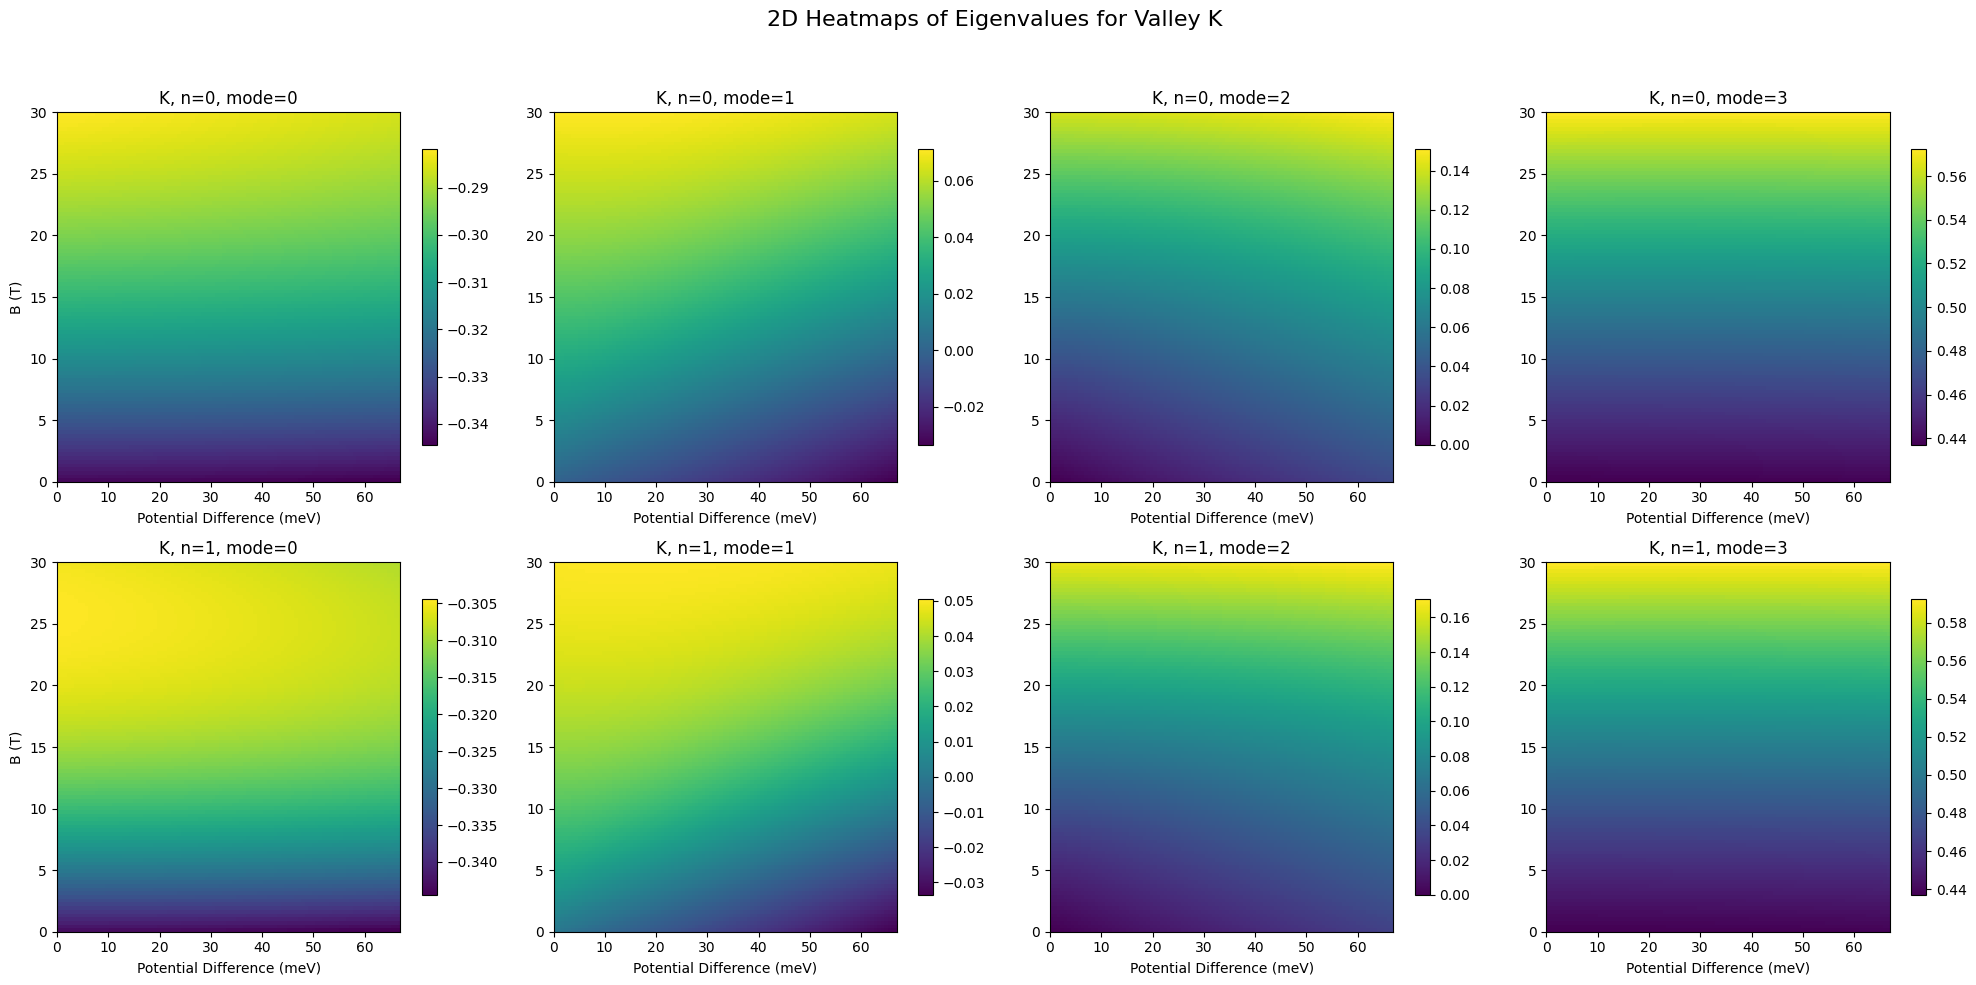

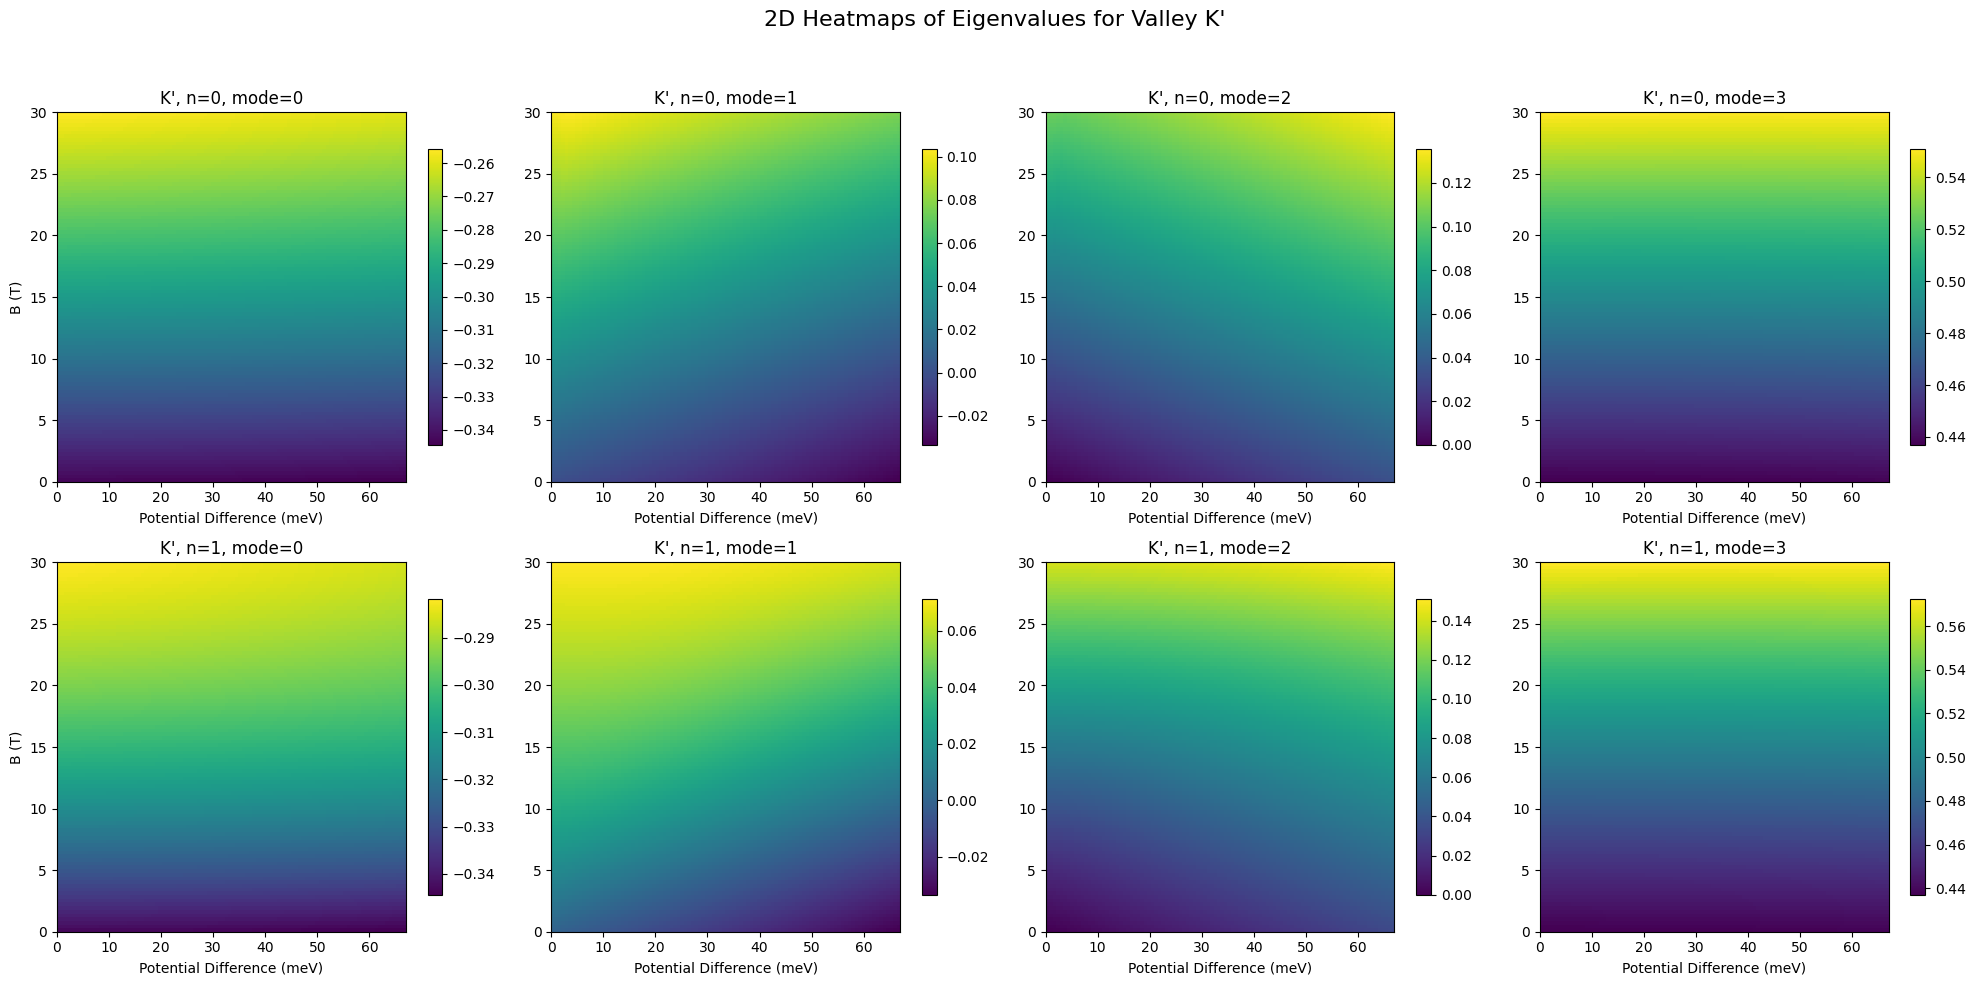

In [48]:
import matplotlib.pyplot as plt

for data, title_prefix in zip(
    [all_eigenvalues_ZS_EF_K_var_B_var_E, all_eigenvalues_ZS_EF_K_prime_var_B_var_E],
    ["K", "K'"]
):
    fig, axes = plt.subplots(len(n_values), 4, figsize=(20, 10))
    fig.suptitle(f"2D Heatmaps of Eigenvalues for Valley {title_prefix}", fontsize=16)

    for i, n in enumerate(n_values):
        for mode in range(4):
            ax = axes[i, mode] if len(n_values) > 1 else axes[mode]
            c = ax.imshow(
                data[i, :, :, mode].T,  # Shape: (B, E)
                extent=[E_values[0] * d * 1e3, E_values[-1] * d * 1e3, B_values[0], B_values[-1]],
                aspect='auto',
                origin='lower',
                cmap='viridis'
            )
            ax.set_title(f'{title_prefix}, n={n}, mode={mode}')
            ax.set_xlabel('Potential Difference (meV)')
            if mode == 0:
                ax.set_ylabel('B (T)')
            fig.colorbar(c, ax=ax, shrink=0.8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("2D_color_plots_of_how_Energy_varies_with_both_E_and_B.pdf", dpi=300, bbox_inches="tight")  # Saves as Pdf
    plt.show()


In [49]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# import numpy as np

# # Create meshgrid for plotting
# E_mesh, B_mesh = np.meshgrid(E_values * d * 1e3, B_values)  # x: E (mV/nm), y: B (T)

# for data, title_prefix in zip(
#     [all_eigenvalues_ZS_EF_K_var_B_var_E, all_eigenvalues_ZS_EF_K_prime_var_B_var_E],
#     ["K", "K'"]
# ):
#     fig = plt.figure(figsize=(20, 10))
#     fig.suptitle(f"3D Surface Plots of Eigenvalues for Valley {title_prefix}", fontsize=16)

#     plot_num = 1
#     for i, n in enumerate(n_values):
#         for mode in range(4):
#             ax = fig.add_subplot(len(n_values), 4, plot_num, projection='3d')
#             Z = data[i, :, :, mode].T  # Shape (B, E) => match meshgrid
#             surf = ax.plot_surface(E_mesh, B_mesh, Z, cmap='viridis')
#             ax.set_title(f'{title_prefix}, n={n}, mode={mode}')
#             ax.set_xlabel('E (mV/nm)')
#             ax.set_ylabel('B (T)')
#             ax.set_zlabel('Energy (eV)')
#             plot_num += 1

#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()
